# Hirshfeld-I charge analysis #

HI charges are calculated using the Hirshfeld module of the HIVE3 software package. __[1,2,3]__


### (Relevant) Numerical settings: ###
#### VASP: ####
* ENCUT = 1000 eV
* PREC = Accurate
* LASPH = .TRUE.
* KPOINTS: Gamma-centered 33x33x33 gridpoints (for all)
* POTCAR -> 'std' or 'GW' set __[4]__

#### Hirshfeld-I: ####
* Hirshfeld precision = 0.0001
* maxit = 150
* stepfunction iterations = 3
* grid = 1202
* interpolation order = 4
* density threshold 1 = 1.0E-7
* density threshold 2 = 1.0E-12
* radfac = 1.0
* coefficient limit = 1.0E-12<br/>

In some cases (~2%), an unfortunate positioning of spherical gridpoints destabilized the algorithm. This was resolved to increasing *radfac = 2.3*. In case of the unaries, the diamond cells of Er, Ga, Ho, In, and La, proved somewhat pathological. In these cases, *grid* and *radfac* were manually tunned to stabilize the Hirshfeld-I algorithm using the following settings:

| El. | *grid* | *radfac* |
|---|---|---|
| **Er** | 1202  | 2.3 |
| **Ga** | 5180  | 1.0 |
| **Ho** | 2030  | 2.3 |
| **In** | 2030  | 2.3 |
| **La** | 2030  | 2.3 | 


### References ###
__[1]__ D. E. P. Vanpoucke, P. Bultinck, and I. Van Driessche, *J. Comput. Chem.* **34(5)**, 405-417 (2013),
doi:[10.1002/jcc.23088](https://dx.doi.org/10.1002/jcc.23088)<br/>
__[2]__ D. E. P. Vanpoucke, I. Van Driessche, and P. Bultinck, *J. Comput. Chem.* **34(5)**, 422-427 (2013),
doi:[10.1002/jcc.23193](https://dx.doi.org/10.1002/jcc.23193)<br/>
__[3]__ *HIVE software*, [github](https://github.com/DannyVanpoucke/HIVE4-tools)<br/>
__[4]__ Current Paper: Accuracy consortium<br/>


## 1. Importing libraries & setting up supporting functions ##

In [1]:
#libraries

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas
import pandas as pd
import numpy as np
import matplotlib
import matplotlib as mpl, matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, LogLocator

# Note: mendeleev needs to be version 0.7.0
import mendeleev
from mendeleev import element
from mendeleev.fetch import fetch_table
from mendeleev.plotting import periodic_plot

import bokeh
from bokeh.plotting import output_notebook, output_file
from bokeh.io import export_png
output_notebook()
print("mendeleev version ",mendeleev.__version__)
print("bokeh version ",bokeh.__version__)
print("pandas version ",pandas.__version__)
print("matplotlib version ",matplotlib.__version__)

ModuleNotFoundError: No module named 'mendeleev.plotting'

In [5]:
#supporting functions

def PlotHistogram(dat: dict={}, xmin: float=0, xmax: float=10, xgrid: int=100,
                  HistType : str=None, CurveType: str=None,
                  labels: dict={'Title':"TITLE",'X':"X",'Y':"Y"}, 
                  exclude: list=[],
                  SaveAs: str=None):
    """
    Plot a 1D lists of data as a histogram.
    
    parameters:
        - dat    : dict of lists of data values (1D)
                   NOTE: there needs to be an "all" dataset, which is used for normalisation.
        - xmin, xmax : min and max value of the xrange (default [0..10])
        - xgrid   : number of bin-intervals (default=100)
        - Htype   : Type of histogram ['DOS','pct','pctlog'] Default='DOS'
        - CurveType : Type of curve to use in the plot ['Cont','Block'], Default='Cont'
        - labels  : dict with the different lables: [Title, X, Y]
        - exclude : list of curves to exclude.
        - SaveAs  : string of the name you want to save the image as. If None, no image is saved.
    """
    if HistType is None:
        HistType = 'DOS'
    if CurveType is None:
        CurveType = 'Cont'
    ## 1. Create Histogram
    binedge=list()
    binsize=(xmax-xmin)/xgrid
    for i in range(xgrid+1):
        binedge.append(xmin+i*binsize)        
    
    maxhist = list()
    HistDict = dict()
    datasize = len(dat['all'])
    for dataname,data in dat.items():
        Hist=np.array([0.0]*xgrid)
        for el in data:
            idx=int(np.floor((el-xmin)/binsize))
            #print('charge=',el,' -> xmin & binsize=',xmin,' & ',binsize,' => ',idx,' bincentre=',bincenter[idx])
            if idx>=0 and idx<xgrid:
                Hist[idx]+=1
    
        if HistType=='DOS':
            Hist=(Hist/datasize)/binsize #histogram in DOS, normaized to 1
        elif HistType in {'pct','pctlog'}:
            Hist=(Hist/datasize)*100 #histogram in % of the total ...not normalized
        HistDict[dataname]=Hist
        maxhist.append(np.max(Hist))
    
    if HistType=='DOS':
        ystep=0.1
    elif HistType in {'pct','pctlog'}:
        ystep=10
            
    ymin=0
    ymax=np.max([(np.floor((np.max(maxhist))/ystep)+1)*ystep,ystep*10.0])
    
    ## 2. the graph
    mpl.rcParams.update(mpl.rcParamsDefault) 
    #plt.style.use('./GraphStyle.mplstyle') #this is broken in a new version of mpl as it is now seen as a package...python fails again
#     styledict={'axes.titlesize' : 24, 'axes.titleweight' : 'bold', 'axes.titlecolor' : 'black',
#             'axes.labelsize' : 22, 'axes.labelweight' : 'bold', 'axes.linewidth' : 3,  'font.weight' : 'bold',
#             'xtick.top' : True, 'xtick.bottom' : True, 'xtick.major.size' : 12, 'xtick.major.width' : 3,
#             'xtick.minor.size' : 6, 'xtick.minor.width' : 2, 'xtick.labelsize' : 18, 'xtick.direction': 'in',
#             'xtick.minor.visible' : True, 'ytick.left': True, 'ytick.right': True, 'ytick.major.size':  12,
#             'ytick.minor.size': 6, 'ytick.major.width':   3, 'ytick.minor.width':   2,'ytick.labelsize':  18,
#             'ytick.direction': 'in', 'ytick.minor.visible': True,'ytick.major.left': True,'ytick.major.right': True,
#             'ytick.minor.left': True, 'ytick.minor.right':   True}
    
    styledict={'axes.titlesize' : 28, 'axes.labelsize' : 26, 'xtick.labelsize' : 22, 'ytick.labelsize':  22}
    
    plt.style.use(styledict)
    fig = plt.figure(figsize = (12,8))
    ax  = fig.add_subplot()
    
    Xlst = np.arange(start=xmin,stop=xmax+binsize,step=10**int(np.floor(np.log10(xmax-xmin))))
    scaleTypeX = "linear"
    plt.xscale(scaleTypeX)
    plt.xticks(Xlst)
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))#locminX  MultipleLocator(0.1)
    
    if HistType in {'pctlog'}:
        scaleTypeY = "log"
        ymin=0.1
        ystep = int(np.ceil(np.log10(ymax))-np.floor(np.log10(ymin)))
        Ylst  = np.logspace(np.floor(np.log10(ymin)),np.ceil(np.log10(ymax)),num=ystep+1,base=10)
        locminY = LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
        ax.yaxis.set_minor_locator(locminY)
        yfactor = 1.25
    else:
        scaleTypeY = "linear"
        Ylst = np.arange(start=ymin,stop=ymax+0.5*ystep,step=ystep)
        ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
        yfactor = 1.0
    
    plt.yscale(scaleTypeY)
    plt.yticks(Ylst)
    
    plt.xlabel(labels['X'])
    plt.ylabel(labels['Y'])
    plt.grid(visible = True, which = 'major', axis = 'both', color = 'lightgrey', linestyle = '--', linewidth = 1)
    
    ## 2.5. create rectangular histogram
    collst = ['blue','red','orangered','salmon','green','darkolivegreen','teal']
    cnt = -1
    for dataname, Hist in HistDict.items():
        cnt += 1
        if dataname not in exclude:
            if CurveType == 'Cont':
                HistogramY=Hist
                HistogramX=np.array(binedge[0:-1])+0.5*binsize
            elif CurveType == 'Block':
                HistogramY=np.array([0.0]*(xgrid*4))
                HistogramX=np.array([0.0]*(xgrid*4))
                for i in range(xgrid):
                    HistogramY[i*4+1:i*4+3]=Hist[i]
                    HistogramX[i*4:i*4+2]=binedge[i]
                    HistogramX[i*4+2:i*4+4]=binedge[i+1]

            colorH = collst[cnt]
            ax.fill_between(HistogramX, HistogramY, color = colorH, zorder = 0, alpha = 0.25)
            ax.plot(HistogramX, HistogramY,  color = colorH, linewidth = 2, zorder = -2,alpha = 0.65, label=dataname)

    ax.legend(fontsize=26)
    plt.axis([xmin,xmax,ymin,ymax*yfactor])
    plt.title(labels['Title'])
    fig.tight_layout() 
    plt.show()
    if SaveAs is not None:
        fig.savefig(SaveAs, bbox_inches='tight')
        plt.close(fig)

## 2. Importing Hirshfeld-I data ##

In [3]:
#### User input #####
HIset = 'AccuracySet_v2'   # Select the dataset: {'STD', 'GW', 'AccuracySet_v2'}

######################
#### Loading data ####
######################
datafile = "HI_"+HIset+".csv"

## Two ways of storing the data:
## 1. the data-dict
##    Dictionary over all metals
##          |--> For each metal linked to a list of oxidation states [None,1..6] 
##                 |--> Each oxidation state gives a dict of data:
##                                      formula: string with chemical formula 
##                                      Qmetal : list of metal charges
##                                      Qoxygen: list of oxygen charges
data  = dict()
## 2. pandas dataframe with 7 colums:
##        metal   : the metal name (string)
##        formula : the chemical formula (string)
##        Qform   : formal charge of the metal (+1..+6)
##        Qm_avg  : average metal charge
##        Qm_std  : standard deviation of the metal charges
##        Qo_avg  : average oxygen charge
##        Qo_std  : standard deviation of the oxygen charges

panda = pd.DataFrame(columns=['metal','formula','Qform','Qm_avg','Qm_std','Qo_avg','Qo_std'])
with open(datafile) as f:
    lines   = f.readlines()
    for line in lines:
        fields = list()
        fields.extend(line.split(';')[0:3])
        fields.extend(int(x) for x in line.split(';')[3:6])
        fields.extend(float(x) for x in line.split(';')[6:6+fields[4]+fields[5]])
        ## Fields:
        # 0 : folder name
        # 1 : chem-formula
        # 2 : metal
        # 3 : formal metal charge (+1..+6)
        # 4 : #metal atoms in cell : m
        # 5 : #oxygen atoms in cell: n
        # 6..5+m+n : sequence of charges, Metal charges first.
        if fields[2].strip() not in data:
            data[fields[2].strip()] = [None,1,2,3,4,5,6]
        mater = dict()
        mater['formula'] = fields[1].strip()
        mater['Qmetal']  = fields[6:6+fields[4]]
        mater['Qoxygen'] = fields[6+fields[4]:6+fields[4]+fields[5]]
        data[fields[2].strip()][fields[3]] = mater
        bamboo = dict()
        bamboo['metal']   = fields[2].strip()
        bamboo['formula'] = fields[1].strip()
        bamboo['Qform']   = fields[3]
        bamboo['Qm_avg']  = np.mean(fields[6:6+fields[4]],axis=0)
        bamboo['Qm_std']  = np.std(fields[6:6+fields[4]],axis=0)
        bamboo['Qo_avg']  = np.mean(fields[6+fields[4]:6+fields[4]+fields[5]])
        bamboo['Qo_std']  = np.std(fields[6+fields[4]:6+fields[4]+fields[5]])
        panda = panda.append(bamboo, ignore_index=True)

print(panda.head())

  metal formula Qform    Qm_avg        Qm_std    Qo_avg        Qo_std
0    Ac    Ac2O     1  0.342401  2.450000e-07 -0.684266  0.000000e+00
1    Ac   Ac2O3     3  1.813077  5.584577e-08 -1.208640  1.105542e-08
2    Ac   Ac2O5     5  2.216651  6.417749e-08 -0.886894  1.642270e-01
3    Ac     AcO     2  1.026238  0.000000e+00 -1.025644  0.000000e+00
4    Ac    AcO2     4  2.182494  0.000000e+00 -1.091502  4.000000e-08


## 3. Data analysis ##

### 3.1. Oxygen charges ###

In introductory chemistry, the oxidation state of an atom in a compound is determined following a set of simple postulates. These may vary between textbooks, but in general they will contain a postulate stating the oxidation number of oxygen to be -2. This is often followed by two possible exceptions:
 1. Oxygen belonging to a peroxide (R-O-O-R configuration) has an oxidation number of -1.
 2. Oxygen bonded to fluorine has an oxidation number of +1.

Our dataset considers six different crystal structures (which are kept fixed, only volume relaxation is allowed) aimed at artificially creating six different formal oxidation states for the *metal* (or non-oxygen): +1 (X<sub>2</sub>O),+2 (XO),+3 (X<sub>2</sub>O<sub>3</sub>),+4 (XO<sub>2</sub>),+5 (X<sub>2</sub>O<sub>5</sub>), and +6 (XO<sub>3</sub>). In each of these crystal structures, the oxygens are never bound to one-another, so no peroxide behavior is expected. Furthermore, in all crystal structure except (X<sub>2</sub>O<sub>5</sub>), all oxygen atoms have the same coordination. In the X<sub>2</sub>O<sub>5</sub> crystal structure, however, two oxygens have a 6-fold coordination, while the other three have a tetrahedral 4-fold coordination.

|      | Ox. M | Coord. M | Coord. O |
|------|-------|----------|----------|
| X2O  | +1    | 4        | 8        |
| XO   | +2    | 6        | 6        |
| X2O3 | +3    | 6        | 4        |
| XO2  | +4    | 8        | 4        |
| X2O5 | +5    | 12       | 4/6      |
| XO3  | +6    | 6        | 2        |

### 3.2. Results for oxygen ###
In the cells below, we present the distribution of the oxygen charges of the entire dataset. In contrast to the chemical intuition of formal charges, the oxygen atoms present a rather wide range of charges varying from almost -2 up to about +0.3. Interestingly, looking at the standard deviation of the oxygen charges calculated for the individual materials, we notice that these are below 1.0E-6 electron for all materials except the X<sub>2</sub>O<sub>5</sub> geometries, which upon further investigation is shown to be the consequence of distinct oxygen charges associated with the oxygen coordination.
Also of interest is the fact that the variation of the oxygen charges is the same for each of the metal oxidation states.

Visualization of the oxygen charges as function of the metal shows a strong variation in charge between the different formal oxidation states. Where the group I elements give rise to the most negative charge for low oxidation numbers, this trend shifts to the center of the d-block for the larger oxidation numbers. As expected, in case of Fluorine the oxygen charge even becomes positive.  



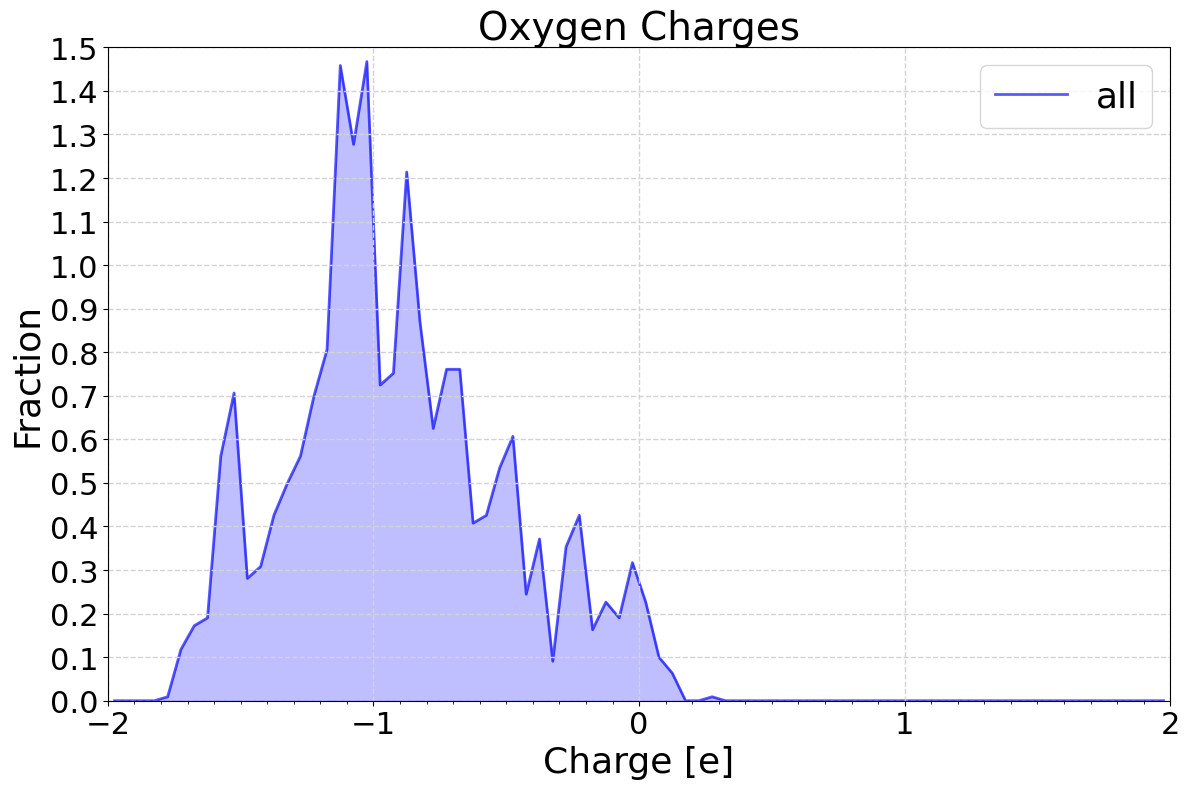

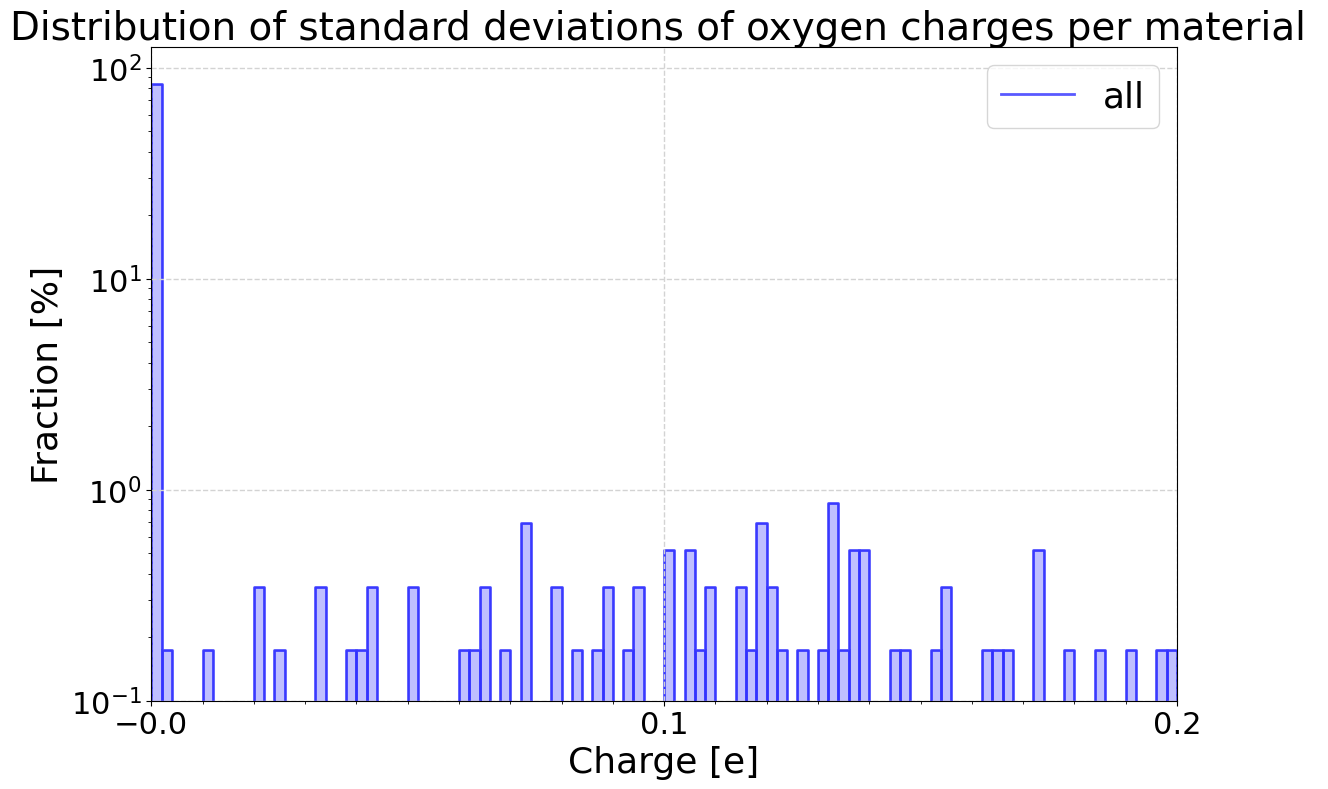

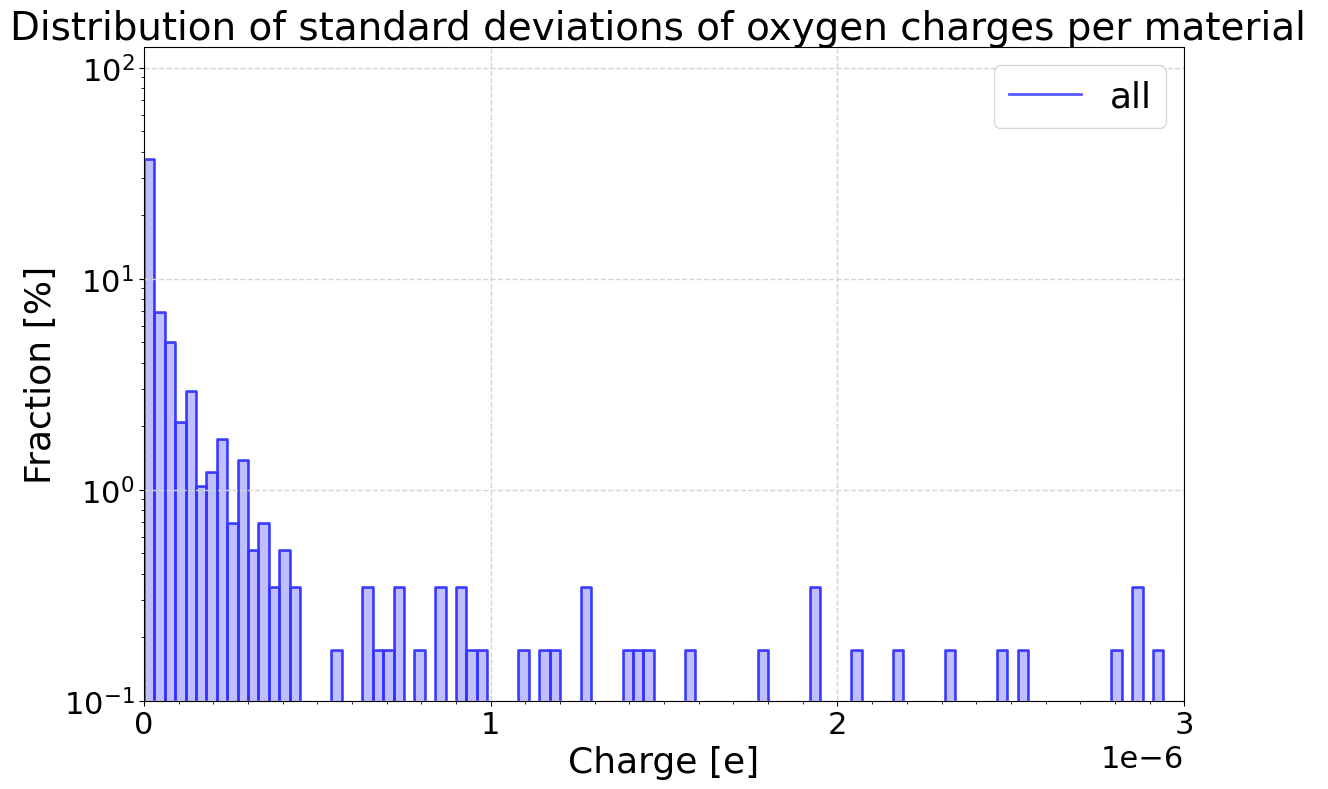

In [6]:
## General overview of oxygen charges
OxCharges=list() # all indivual charges
OxStd=list()     # all standard deviations for the different oxidation states of the different metals

for metal in data.values():
    for i in range(1,7):
        if not (metal[i] == i):
            OxCharges.extend(metal[i]['Qoxygen'])
OxStd=list(panda['Qo_std'])

PlotHistogram({'all':OxCharges}, xmin=-2, xmax=2, xgrid=80, HistType='DOS', 
                  labels={'Title':"Oxygen Charges",'X':"Charge [e]",'Y':"Fraction"})
PlotHistogram({'all':OxStd}, xmin=-0.1e-5, xmax=0.2, xgrid=100, HistType='pctlog', CurveType='Block',
                  labels={'Title':"Distribution of standard deviations of oxygen charges per material ",
                          'X':"Charge [e]",'Y':"Fraction [%]"})
PlotHistogram({'all':OxStd}, xmin=0, xmax=3.0e-6, xgrid=100, HistType='pctlog', CurveType='Block',
                  labels={'Title':"Distribution of standard deviations of oxygen charges per material ",
                          'X':"Charge [e]",'Y':"Fraction [%]"})

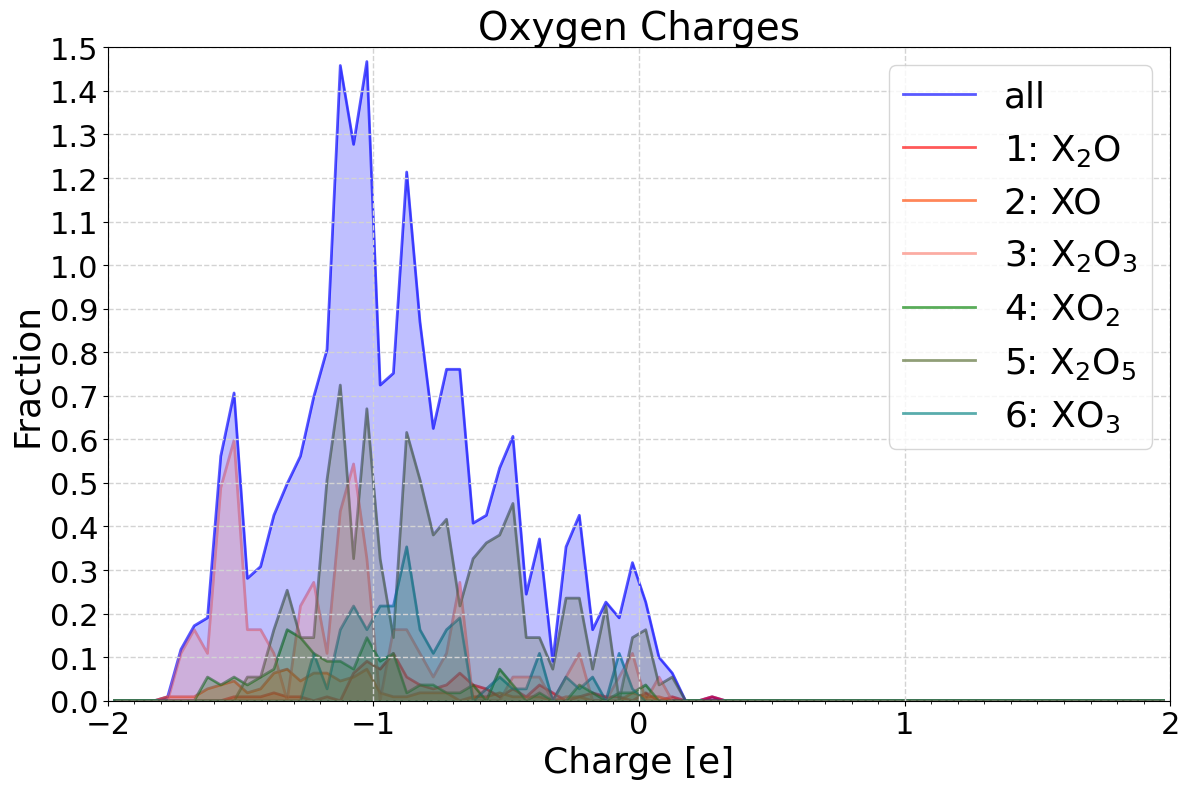

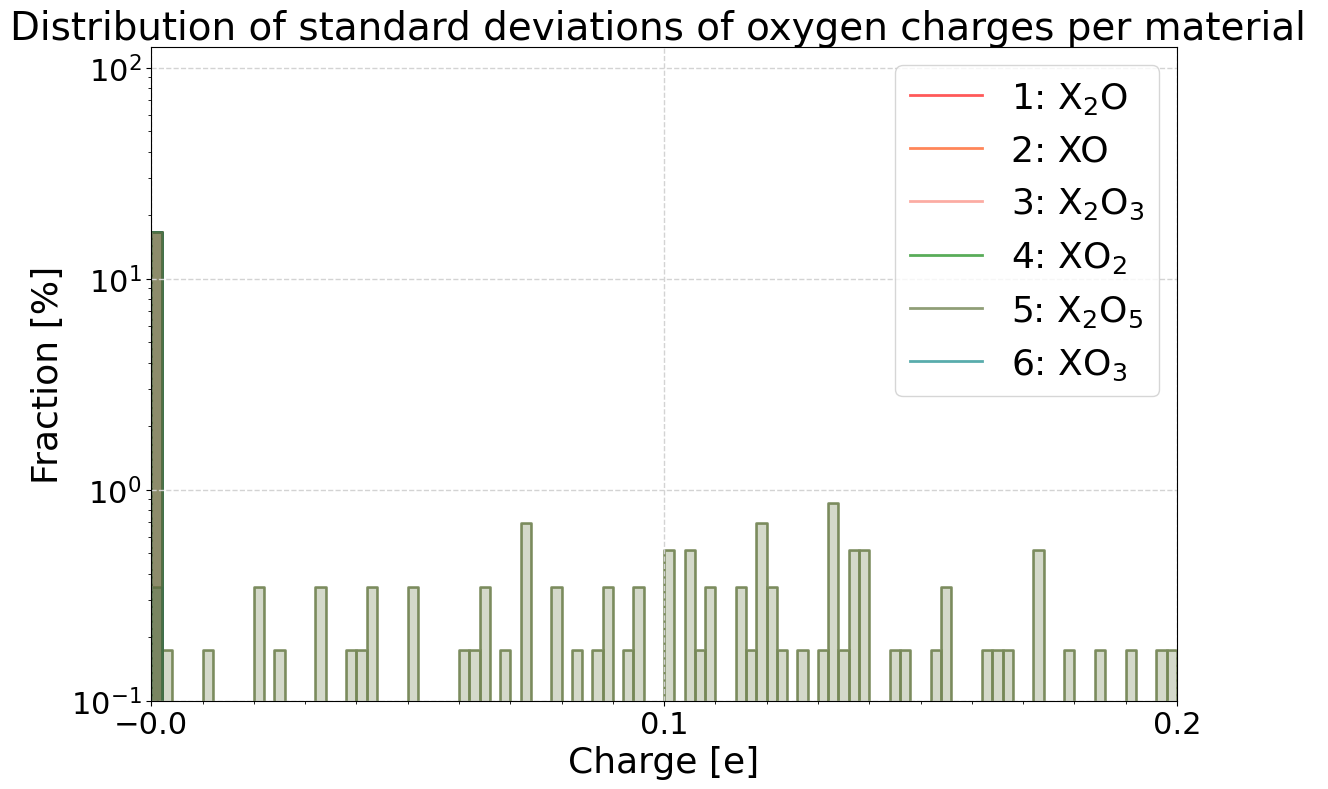

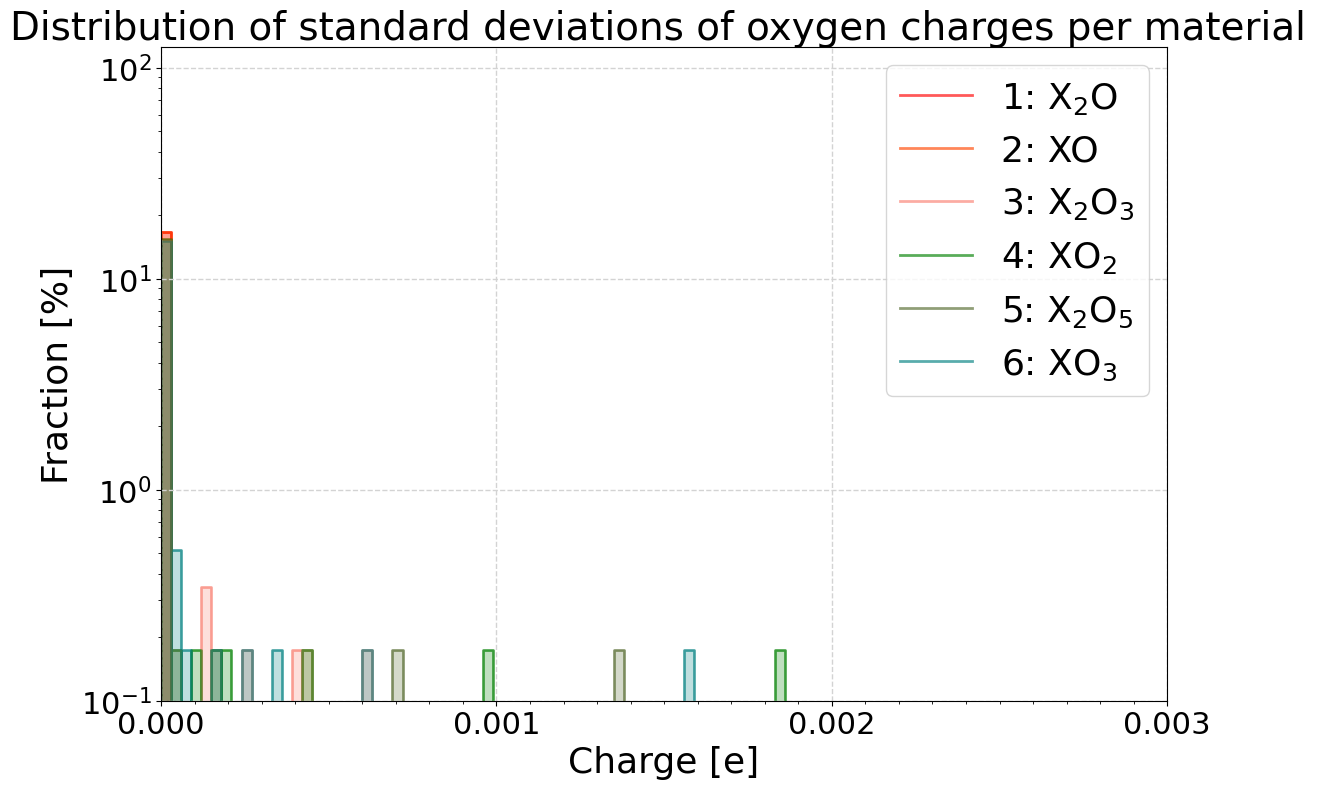

In [9]:
## General overview of oxygen charges
OxChargeD=dict() # all indivual charges
OxStdD=dict()     # all standard deviations for the different oxidation states of the different metals

OxChargeD['all']=OxCharges
OxStdD['all']=OxStd


OxLst=['all','1: X$_2$O','2: XO','3: X$_2$O$_3$','4: XO$_2$','5: X$_2$O$_5$','6: XO$_3$']
for cnt in range(1,7):
    OxChargeD[OxLst[cnt]] = list()
    OxStdD[OxLst[cnt]] = list()

for metal in data.values():
    for i in range(1,7):
        if not (metal[i] == i):
            OxChargeD[OxLst[i]].extend(metal[i]['Qoxygen'])
            OxStdD[OxLst[i]].append(np.std(metal[i]['Qoxygen']))
            
PlotHistogram(OxChargeD, xmin=-2, xmax=2, xgrid=80, HistType='DOS', 
                  labels={'Title':"Oxygen Charges",'X':"Charge [e]",'Y':"Fraction"},
                  SaveAs="OCharges_Allsubsets.pdf")
PlotHistogram(OxStdD, xmin=-0.1e-5, xmax=0.2, xgrid=100, HistType='pctlog', CurveType='Block',
                  labels={'Title':"Distribution of standard deviations of oxygen charges per material ",
                          'X':"Charge [e]",'Y':"Fraction [%]"}, exclude=['all'])
PlotHistogram(OxStdD, xmin=0, xmax=3.0e-3, xgrid=100, HistType='pctlog', CurveType='Block',
                  labels={'Title':"Distribution of standard deviations of oxygen charges per material ",
                          'X':"Charge [e]",'Y':"Fraction [%]"}, exclude=['all'])

In [ ]:
# Periodic table dimensions
PT_W = 980
PT_H = 640

#Plot charges as periodic table
ptable = fetch_table('elements') #get a pandas periodic table of elements

#panda = pd.DataFrame(columns=['metal','formula','Qform','Qm_avg','Qm_std','Qo_avg','Qo_std'])
eldict = [dict(),dict(),dict(),dict(),dict(),dict()] #one dictionary per formal charge
for i, row in panda.iterrows():
    eldict[row['Qform']-1][row['metal']] = row['Qo_avg']
#transform from string to Z-number
for OX in range(6):
    #print('OX=',OX,' len eldict=',len(eldict))
    allels = dict([(element(x[0]).atomic_number,x[1]) for x in eldict[OX].items()])
    for i in range(1,119):
        if i not in allels.keys():
            allels[i] = float("NaN") # use NaN to exclude missing data
    temp = pd.DataFrame(allels.items(),index=allels.keys()).sort_values(by=0)
    Ocharges = temp[1].astype('float32').round(3)
    ptable['OX'+str(OX+1)] = [np.round(x,3) if np.isnan(x) == False else float("NaN") for x in Ocharges ]
    periodic_plot(ptable, attribute='OX'+str(OX+1), colorby='attribute',
              title='Oxygen charge for metal oxidation number = '+str(OX+1),decimals=3, width=PT_W, height=PT_H)
    atname = 'OX'+str(OX+1)
    print(atname,type(atname))

### 3.3. Metal charges ###


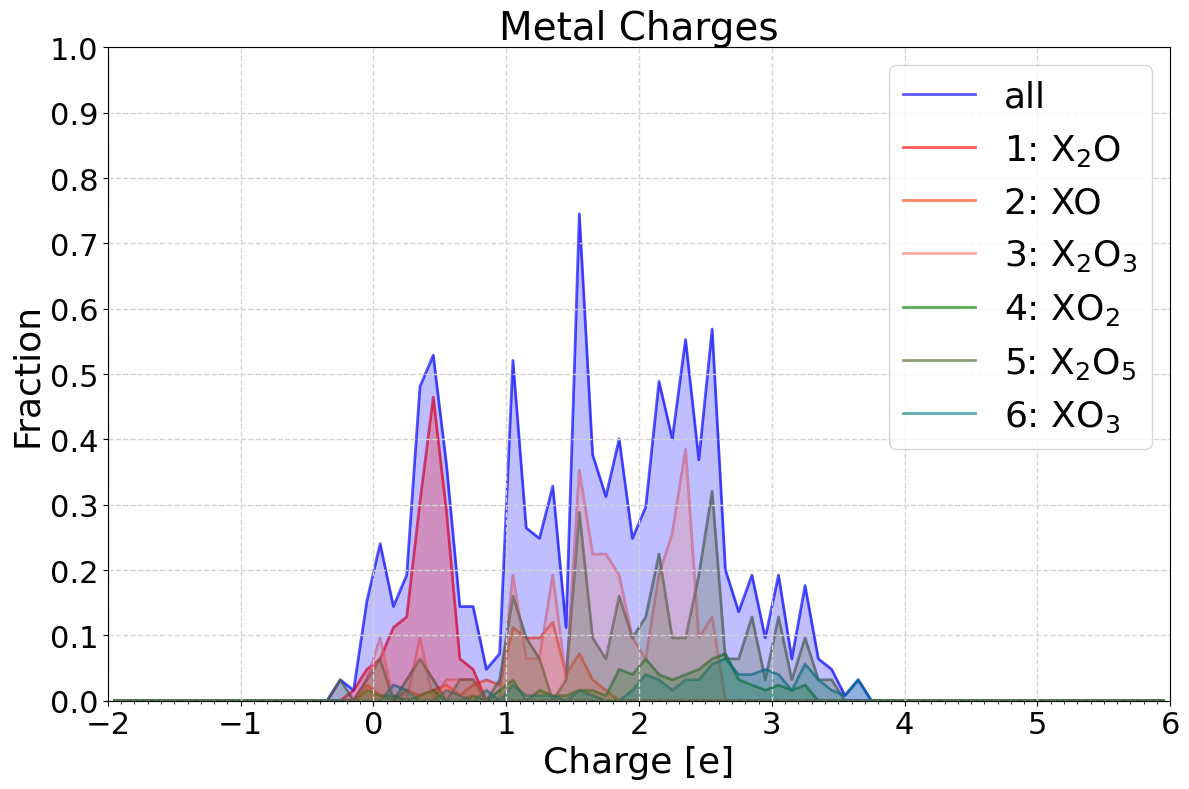

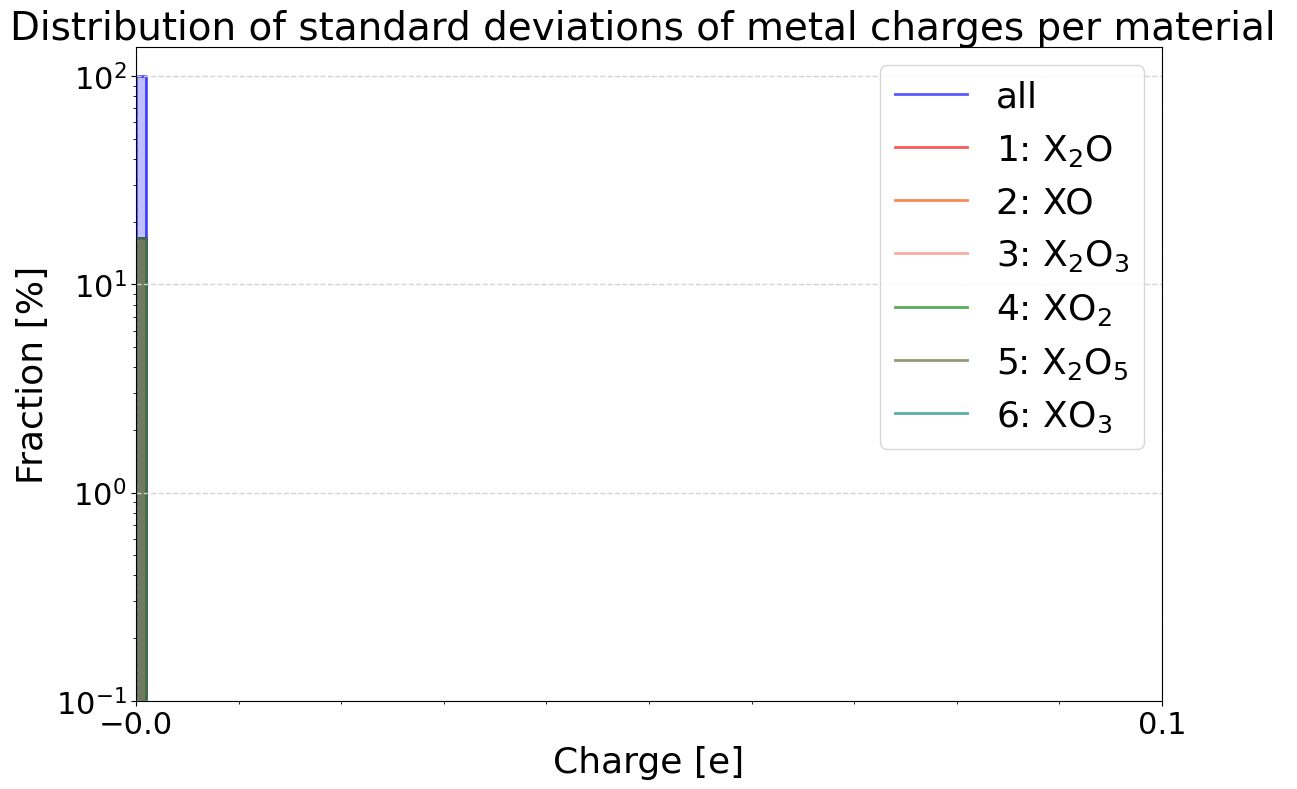

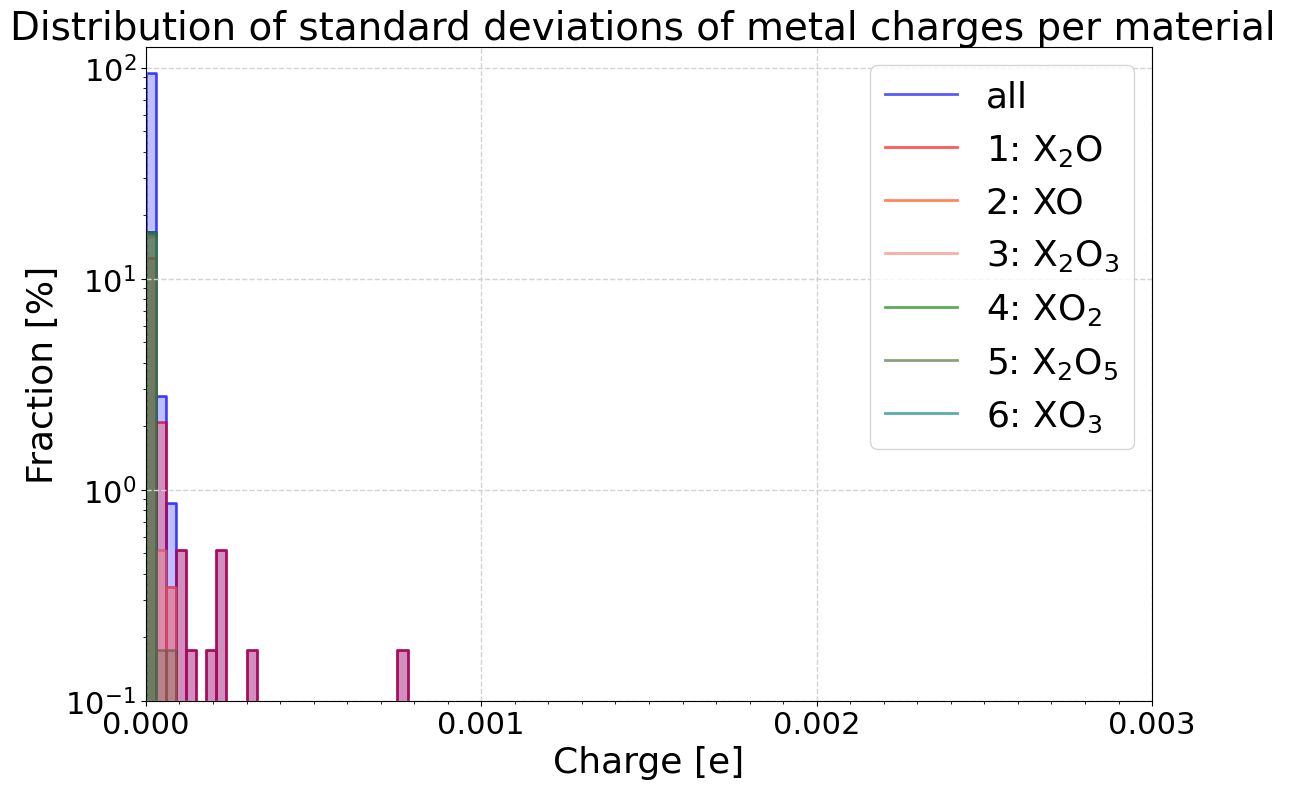

In [10]:
## General overview of the metal charges
MCharges=list() # all indivual charges
MStd=list()     # all standard deviations for the different oxidation states of the different metals
for metal in data.values():
    for i in range(1,7):
        if not (metal[i] == i):
            MCharges.extend(metal[i]['Qmetal'])
MStd=list(panda['Qm_std'])

MChargeD=dict() # all indivual charges
MStdD=dict()     # all standard deviations for the different oxidation states of the different metals
MChargeD['all']=MCharges
MStdD['all']=MStd

OxLst=['all','1: X$_2$O','2: XO','3: X$_2$O$_3$','4: XO$_2$','5: X$_2$O$_5$','6: XO$_3$']
for cnt in range(1,7):
    MChargeD[OxLst[cnt]] = list()
    MStdD[OxLst[cnt]] = list()

for metal in data.values():
    for i in range(1,7):
        if not (metal[i] == i):
            MChargeD[OxLst[i]].extend(metal[i]['Qmetal'])
            MStdD[OxLst[i]].append(np.std(metal[i]['Qmetal']))
            
PlotHistogram(MChargeD, xmin=-2, xmax=6, xgrid=80, HistType='DOS', 
                  labels={'Title':"Metal Charges",'X':"Charge [e]",'Y':"Fraction"},
                  SaveAs="MetalCharges_Allsubsets.pdf")
PlotHistogram(MStdD, xmin=-0.1e-5, xmax=0.1, xgrid=100, HistType='pctlog', CurveType='Block',
                  labels={'Title':"Distribution of standard deviations of metal charges per material ",
                          'X':"Charge [e]",'Y':"Fraction [%]"}, exclude=[])
PlotHistogram(MStdD, xmin=0, xmax=3.0e-3, xgrid=100, HistType='pctlog', CurveType='Block',
                  labels={'Title':"Distribution of standard deviations of metal charges per material ",
                          'X':"Charge [e]",'Y':"Fraction [%]"}, exclude=[])

In [ ]:
#Plot charges as periodic table
ptable = fetch_table('elements') #get a pandas periodic table of elements

#panda = pd.DataFrame(columns=['metal','formula','Qform','Qm_avg','Qm_std','Qo_avg','Qo_std'])
eldict = [dict(),dict(),dict(),dict(),dict(),dict()] #one dictionary per formal charge
for i, row in panda.iterrows():
    eldict[row['Qform']-1][row['metal']] = row['Qm_avg']
#transform from string to Z-number
for OX in range(6):
    #print('OX=',OX,' len eldict=',len(eldict))
    allels = dict([(element(x[0]).atomic_number,x[1]) for x in eldict[OX].items()])
    for i in range(1,119):
        if i not in allels.keys():
            allels[i] = float("0") # use NaN to exclude missing data
    temp = pd.DataFrame(allels.items(),index=allels.keys()).sort_values(by=0)
    Ocharges = temp[1].astype('float32').round(3)
    ptable['MOX'+str(OX+1)] = [np.round(x,3) if np.isnan(x) == False else float("0") for x in Ocharges ]
   
    periodic_plot(ptable, attribute='MOX'+str(OX+1), colorby='attribute',
              title='Metal charge for metal oxidation number = '+str(OX+1),decimals=3, width=PT_W, height=PT_H)


In [ ]:
df = ptable[['MOX1','MOX2','MOX3','MOX4','MOX5','MOX6','en_allen','group_id','c6']]
print('columns=',ptable.columns)
print(type(df),'\n',df.head())
pd.plotting.scatter_matrix(df,figsize=(12,12));
plt.show()

### 3.4. Metal charges evolution ###


In [15]:
# MaxOxPT & OxMost is based on:  
#     Greenwood, Norman N.; Earnshaw, Alan (1997). 
#     Chemistry of the Elements (2nd ed.). Butterworth-Heinemann. 
#     pp. 27–28. ISBN 978-0-08-037941-8.
# Same values are found on https://en.wikipedia.org/wiki/Oxidation_state, with some updates based on new findings
# Same values are obtained from ptable.com, differences between the three are indicated
# We keep the values of Greenwood as the qualitative picture does not change significantly.

# MaxOxPT: maximum oxidation state observed (including 'non-common' cases)
# OxMost: List of most common oxidation states

MyPT=dict()
MyPT['H']= {'MaxOxPT': 1, 'OxMost':[-1,1]}
MyPT['Li']={'MaxOxPT': 1, 'OxMost':[1]}
MyPT['Na']={'MaxOxPT': 1, 'OxMost':[1]}
MyPT['K']= {'MaxOxPT': 1, 'OxMost':[1]}
MyPT['Rb']={'MaxOxPT': 1, 'OxMost':[1]}
MyPT['Cs']={'MaxOxPT': 1, 'OxMost':[1]}
MyPT['Fr']={'MaxOxPT': 1, 'OxMost':[1]}

MyPT['Be']={'MaxOxPT': 2, 'OxMost':[2]}
MyPT['Mg']={'MaxOxPT': 2, 'OxMost':[2]}
MyPT['Ca']={'MaxOxPT': 2, 'OxMost':[2]}
MyPT['Sr']={'MaxOxPT': 2, 'OxMost':[2]}
MyPT['Ba']={'MaxOxPT': 2, 'OxMost':[2]}
MyPT['Ra']={'MaxOxPT': 2, 'OxMost':[2]}

MyPT['B']= {'MaxOxPT': 3, 'OxMost':[3]}
MyPT['Al']={'MaxOxPT': 3, 'OxMost':[3]}
MyPT['Ga']={'MaxOxPT': 3, 'OxMost':[3]}
MyPT['In']={'MaxOxPT': 3, 'OxMost':[3]}
MyPT['Tl']={'MaxOxPT': 3, 'OxMost':[1,3]}

MyPT['C']= {'MaxOxPT': 4, 'OxMost':[-4,4]}
MyPT['Si']={'MaxOxPT': 4, 'OxMost':[-4,4]}
MyPT['Ge']={'MaxOxPT': 4, 'OxMost':[-4,2,4]}
MyPT['Sn']={'MaxOxPT': 4, 'OxMost':[-4,2,4]}
MyPT['Pb']={'MaxOxPT': 4, 'OxMost':[2,4]}

MyPT['N']= {'MaxOxPT': 5, 'OxMost':[-3,3,5]}
MyPT['P']= {'MaxOxPT': 5, 'OxMost':[-3,3,5]}
MyPT['As']={'MaxOxPT': 5, 'OxMost':[-3,3,5]}
MyPT['Sb']={'MaxOxPT': 5, 'OxMost':[-3,3,5]}
MyPT['Bi']={'MaxOxPT': 5, 'OxMost':[3]}

MyPT['O']= {'MaxOxPT': 2, 'OxMost':[-2]}
MyPT['S']= {'MaxOxPT': 6, 'OxMost':[-2,2,4,6]}
MyPT['Se']={'MaxOxPT': 6, 'OxMost':[-2,2,4,6]}
MyPT['Te']={'MaxOxPT': 6, 'OxMost':[-2,2,4,6]}
MyPT['Po']={'MaxOxPT': 6, 'OxMost':[-2,2,4]} 

MyPT['F']= {'MaxOxPT': -1, 'OxMost':[-1]}
MyPT['Cl']={'MaxOxPT': 7, 'OxMost':[-1,1,3,5,7]}
MyPT['Br']={'MaxOxPT': 7, 'OxMost':[-1,1,3,5]}
MyPT['I']= {'MaxOxPT': 7, 'OxMost':[-1,1,3,5,7]}
MyPT['At']={'MaxOxPT': 7, 'OxMost':[-1,1]}

MyPT['He']={'MaxOxPT': 0, 'OxMost':[0]}
MyPT['Ne']={'MaxOxPT': 0, 'OxMost':[0]}
MyPT['Ar']={'MaxOxPT': 0, 'OxMost':[0]}
MyPT['Kr']={'MaxOxPT': 2, 'OxMost':[2]}
MyPT['Xe']={'MaxOxPT': 8, 'OxMost':[2,4,6]}
MyPT['Rn']={'MaxOxPT': 0, 'OxMost':[0]} #Note: PTable notes +2 as most common oxidation state, 
                                        #      as well as wikipedia which provides reference

# d-block
MyPT['Sc']={'MaxOxPT': 3, 'OxMost':[3]}
MyPT['Y'] ={'MaxOxPT': 3, 'OxMost':[3]}
MyPT['Ti']={'MaxOxPT': 4, 'OxMost':[4]}
MyPT['Zr']={'MaxOxPT': 4, 'OxMost':[4]}
MyPT['Hf']={'MaxOxPT': 4, 'OxMost':[4]}
MyPT['V'] ={'MaxOxPT': 5, 'OxMost':[5]}
MyPT['Nb']={'MaxOxPT': 5, 'OxMost':[5]}
MyPT['Ta']={'MaxOxPT': 5, 'OxMost':[5]}
MyPT['Cr']={'MaxOxPT': 6, 'OxMost':[3,6]}
MyPT['Mo']={'MaxOxPT': 6, 'OxMost':[4,6]}
MyPT['W'] ={'MaxOxPT': 6, 'OxMost':[4,6]}
MyPT['Mn']={'MaxOxPT': 7, 'OxMost':[2,4,7]}
MyPT['Tc']={'MaxOxPT': 7, 'OxMost':[4,7]}
MyPT['Re']={'MaxOxPT': 7, 'OxMost':[4]}
MyPT['Fe']={'MaxOxPT': 6, 'OxMost':[2,3]}
MyPT['Ru']={'MaxOxPT': 8, 'OxMost':[3,4]}
MyPT['Os']={'MaxOxPT': 8, 'OxMost':[4]}
MyPT['Co']={'MaxOxPT': 5, 'OxMost':[2,3]}
MyPT['Rh']={'MaxOxPT': 6, 'OxMost':[3]}
MyPT['Ir']={'MaxOxPT': 6, 'OxMost':[3,4]} # Greenwood notes +6 as max, Ptable +8, 
                                            # while wikipedia goes to +9 (refs, and includes +1 as common)
MyPT['Ni']={'MaxOxPT': 4, 'OxMost':[2]}
MyPT['Pd']={'MaxOxPT': 4, 'OxMost':[2,4]}
MyPT['Pt']={'MaxOxPT': 6, 'OxMost':[2,4]}
MyPT['Cu']={'MaxOxPT': 4, 'OxMost':[2]}
MyPT['Ag']={'MaxOxPT': 3, 'OxMost':[1]}  # ptable indicates 4 as max, same for wikipedia 
MyPT['Au']={'MaxOxPT': 5, 'OxMost':[3]}
MyPT['Zn']={'MaxOxPT': 2, 'OxMost':[2]}
MyPT['Cd']={'MaxOxPT': 2, 'OxMost':[2]}
MyPT['Hg']={'MaxOxPT': 2, 'OxMost':[1,2]} # ptable indicates 4 as max, wikipedia does also not include +4

# f-block
MyPT['La']={'MaxOxPT': 3, 'OxMost':[3]}
MyPT['Ce']={'MaxOxPT': 4, 'OxMost':[3,4]}
MyPT['Pr']={'MaxOxPT': 4, 'OxMost':[3]}
MyPT['Nd']={'MaxOxPT': 3, 'OxMost':[3]}
MyPT['Pm']={'MaxOxPT': 3, 'OxMost':[3]}
MyPT['Sm']={'MaxOxPT': 3, 'OxMost':[3]}
MyPT['Eu']={'MaxOxPT': 3, 'OxMost':[2,3]}
MyPT['Gd']={'MaxOxPT': 3, 'OxMost':[3]}
MyPT['Tb']={'MaxOxPT': 4, 'OxMost':[3]}
MyPT['Dy']={'MaxOxPT': 3, 'OxMost':[3]}
MyPT['Ho']={'MaxOxPT': 3, 'OxMost':[3]}
MyPT['Er']={'MaxOxPT': 3, 'OxMost':[3]}
MyPT['Tm']={'MaxOxPT': 3, 'OxMost':[3]}
MyPT['Yb']={'MaxOxPT': 3, 'OxMost':[3]}
MyPT['Lu']={'MaxOxPT': 3, 'OxMost':[3]}

MyPT['Ac']={'MaxOxPT': 3, 'OxMost':[3]}
MyPT['Th']={'MaxOxPT': 4, 'OxMost':[4]}
MyPT['Pa']={'MaxOxPT': 5, 'OxMost':[5]}
MyPT['U'] ={'MaxOxPT': 6, 'OxMost':[6]}
MyPT['Np']={'MaxOxPT': 7, 'OxMost':[5]}
MyPT['Pu']={'MaxOxPT': 7, 'OxMost':[4]} #ptable indicates 8 as max, wikipedia as well
MyPT['Am']={'MaxOxPT': 6, 'OxMost':[3]}
MyPT['Cm']={'MaxOxPT': 4, 'OxMost':[3]}


In [16]:
def PlotCorrelatie(xData: list=[],yData: list=[],cData: list=[], 
                  labels: dict={'Title':"TITLE",'X':"X",'Y':"Y"}, 
                  Opt: str=None, 
                  SaveAs: str=None):
    """
    Plot a 1D lists of data as a histogram.
    
    parameters:
        - xData   : The X-coordinates (Formal Oxidation list for each point)
        - yData   : The y-coordinate  (the HI charge)
        - cData   : The list of chemical element for each point
        - labels  : dict with the different lables: [Title, X, Y]
        - Opt     : string with option: {'correlation','violinMaxOxPT','violinOxMost'}, Default='correlation'
        - SaveAs  : string of the name you want to save the image as. If None, no image is saved.
    """
    if Opt is None:
        Opt='correlation'
        
    xmin = 0.00
    xmax = 7.00
    ymin = -0.50
    ymax = 4.00
    ystep= 0.25
    
    
    ## 1. the graph
    mpl.rcParams.update(mpl.rcParamsDefault) 
    #plt.style.use('./GraphStyle.mplstyle') this option is now broken by MPL...
    
#     styledict={'axes.titlesize' : 24, 'axes.titleweight' : 'bold', 'axes.titlecolor' : 'black',
#             'axes.labelsize' : 22, 'axes.labelweight' : 'bold', 'axes.linewidth' : 3,  'font.weight' : 'bold',
#             'xtick.top' : True, 'xtick.bottom' : True, 'xtick.major.size' : 12, 'xtick.major.width' : 3,
#             'xtick.minor.size' : 6, 'xtick.minor.width' : 2, 'xtick.labelsize' : 18, 'xtick.direction': 'in',
#             'xtick.minor.visible' : True, 'ytick.left': True, 'ytick.right': True, 'ytick.major.size':  12,
#             'ytick.minor.size': 6, 'ytick.major.width':   3, 'ytick.minor.width':   2,'ytick.labelsize':  18,
#             'ytick.direction': 'in', 'ytick.minor.visible': True,'ytick.major.left': True,'ytick.major.right': True,
#             'ytick.minor.left': True, 'ytick.minor.right':   True}
    
    styledict={'axes.titlesize' : 26, 'axes.labelsize' : 24, 'xtick.labelsize' : 20, 'ytick.labelsize':  20}
    plt.style.use(styledict)
    
    fig = plt.figure(figsize = (12,8))
    ax  = fig.add_subplot()
    viol = fig.add_axes([0,0,1,1])
    
    Xlst = np.arange(start=xmin,stop=xmax,step=1)
    scaleTypeX = "linear"
    plt.xscale(scaleTypeX)
    plt.xticks(Xlst)
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))#locminX  MultipleLocator(0.1)
    scaleTypeY = "linear"
    Ylst = np.arange(start=ymin,stop=ymax,step=ystep)
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
    yfactor = 1.0
    plt.yscale(scaleTypeY)
    plt.yticks(Ylst)
    
    plt.xlabel(labels['X'])
    plt.ylabel(labels['Y'])
    plt.grid(visible = True, which = 'major', axis = 'both', color = 'lightgrey', linewidth = 0)
    
    ## 2.5. create rectangular histogram
    collst = ['blue','red','orangered','salmon','green','darkolivegreen','teal','teal','teal','teal']
    cnt = -1
    
    MaxFormQ=7
    ptcntTot=len(xData)
    ptcntY=0
    ptcntN=0
    
    
    if Opt == 'correlation':
        plt.scatter(xData,yData)
    elif Opt == 'violinMaxOxPT':
        #### All data ####
        yDD=np.array(yData)
        xDD=np.array(xData)
        Yilst=list()
        Xilst=list()
        cl="#000000"
        
        for j in range(1,MaxFormQ):
            Xil=[i for i in range(len(xData)) if xData[i]==j]
            Yi=yDD[Xil]
            Xi=xDD[Xil]
            Yilst.append(list(Yi))
            Xilst.append(list(Xi))
    
        ViolinPlot1 = viol.violinplot(Yilst,
                                showmeans=True, showmedians=False,
                                showextrema=True,widths=1.0)
        for pc in ViolinPlot1['bodies']:
            pc.set_facecolor(cl)
            pc.set_edgecolor(cl)
            pc.set_color(cl)
            pc.set_alpha(0.5)   
        ViolinPlot1['cbars'].set_color(cl)
        ViolinPlot1['cmeans'].set_color(cl)
        ViolinPlot1['cmins'].set_color(cl)
        ViolinPlot1['cmaxes'].set_color(cl)
        
        #### selected data ####
        yDD=np.array(yData)
        xDD=np.array(xData)
        Yilst=list()
        Xilst=list()
        YOilst=list()
        XOilst=list()
        meanXlst=[-1]
        meanYlst=[-1]
    
        fracs=list()
        cl="#00FF00" #green
        for j in range(1,MaxFormQ):
            Xil=[i for i in range(len(xData)) if (xData[i]==j) and (j<=MyPT[cData[i]]['MaxOxPT'])]
            ptcntY+=len(Xil)
            fracs.append(len(Xil))
            Yi=yDD[Xil]
            Xi=xDD[Xil]
            meanXlst.append(np.mean(Xi))
            meanYlst.append(np.mean(Yi))
            Yilst.append(list(Yi))
            Xilst.append(list(Xi))
        for j in range(1,MaxFormQ):
            plt.scatter(Xilst[j-1],Yilst[j-1],color=cl, alpha=0.5)
        m, b = np.polyfit(meanXlst, meanYlst, 1)
        plt.plot(meanXlst, m*np.array(meanXlst)+b, color=cl, ls="dashed", linewidth=2)
        
        fracs=list()
        meanXlst=[-1]
        meanYlst=[-1]
        cl="#3333EE" #blue
        for j in range(1,MaxFormQ):
            Xil=[i for i in range(len(xData)) if (xData[i]==j) and (j>MyPT[cData[i]]['MaxOxPT'])]
            ptcntN+=len(Xil)
            fracs.append(len(Xil))
            Yi=yDD[Xil]
            Xi=[x+0.0 for x in xDD[Xil]]
            meanXlst.append(np.mean(Xi))
            meanYlst.append(np.mean(Yi))
            #print(Xi)
            YOilst.append(list(Yi))
            XOilst.append(list(Xi))
        for j in range(1,MaxFormQ):
            plt.scatter(XOilst[j-1],YOilst[j-1],color=cl, alpha=0.5)
        m, b = np.polyfit(meanXlst, meanYlst, 1)
        plt.plot(meanXlst, m*np.array(meanXlst)+b, color=cl, ls="dashed", linewidth=2)
        
    elif Opt == 'violinOxMost':
        #### All data ####
        yDD=np.array(yData)
        xDD=np.array(xData)
        Yilst=list()
        Xilst=list()
        TOTsetL=list()
        TOTsetL.append(0)
        for j in range(1,MaxFormQ):
            Xil=[i for i in range(len(xData)) if xData[i]==j]
            print("Total j="+str(j)+" --> "+str(len(Xil)))
            TOTsetL.append(len(Xil))
            Yi=yDD[Xil]
            Xi=xDD[Xil]
            Yilst.append(list(Yi))
            Xilst.append(list(Xi))
    
        ViolinPlot1 = viol.violinplot(Yilst,
                                showmeans=True, showmedians=False,
                                showextrema=True,widths=0.5)
        cl="#000000"
        for pc in ViolinPlot1['bodies']:
            pc.set_facecolor(cl)
            pc.set_edgecolor(cl)
            pc.set_color(cl)
            pc.set_alpha(0.5)   
        ViolinPlot1['cbars'].set_color(cl)
        ViolinPlot1['cmeans'].set_color(cl)
        ViolinPlot1['cmins'].set_color(cl)
        ViolinPlot1['cmaxes'].set_color(cl)
        
        #### selected data ####
        yDD=np.array(yData)
        xDD=np.array(xData)
        Yilst=list()
        Xilst=list()
        YOilst=list()
        XOilst=list()
        
        fracs=list()
        for j in range(1,MaxFormQ):
            Xil=[i for i in range(len(xData)) if (xData[i]==j) and (j in MyPT[cData[i]]['OxMost'])]
            print("Selected j="+str(j)+" --> "+str(len(Xil)))
            ptcntY+=len(Xil)
            fracs.append((len(Xil)*0.5/TOTsetL[j]))
            Yi=yDD[Xil]
            Xi=xDD[Xil]
            Yilst.append(list(Yi))
            Xilst.append(list(Xi))
    
        fracs=list()
        for j in range(1,MaxFormQ):
            Xil=[i for i in range(len(xData)) if (xData[i]==j) and (not j in MyPT[cData[i]]['OxMost'])]
            print("Not Selected j="+str(j)+" --> "+str(len(Xil)))
            ptcntN+=len(Xil)
            fracs.append((len(Xil)*0.5/TOTsetL[j]))
            Yi=yDD[Xil]
            Xi=xDD[Xil]
            YOilst.append(list(Yi))
            XOilst.append(list(Xi))
        cl="#FF0000"
    
    else:
        print("ERROR: Option not found!")
    
    print("Total="+str(ptcntTot)+" = Y "+str(ptcntY)+" + N "+str(ptcntN))

    plt.axis([xmin,xmax,ymin,ymax*yfactor])
    plt.title(labels['Title'])
    #fig.tight_layout() 
    plt.show()
    if SaveAs is not None:
        fig.savefig(SaveAs, bbox_inches="tight")
        plt.close(fig)

Total=576 = Y 361 + N 215


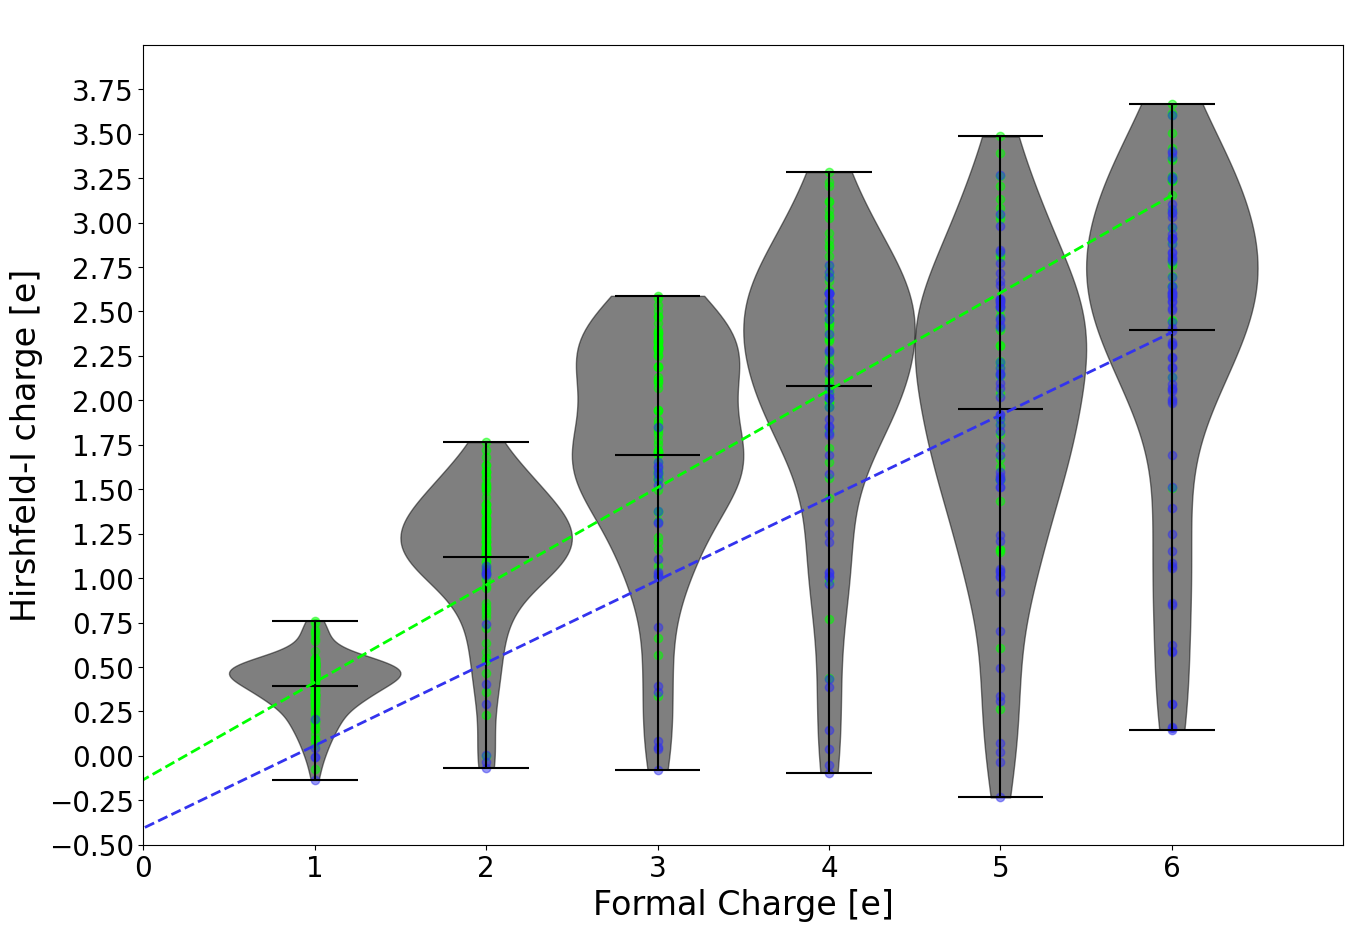

In [17]:
#Correlatieplot
lbls={'Title':" ",'X':"Formal Charge [e]",'Y':"Hirshfeld-I charge [e]"}
xlst=list(panda['Qform']) # will be a list of formal charges
ylst=list(panda['Qm_avg']) # will be a list of HI charges.
chemlst=list(panda['metal']) # will be a list of the metal element.
PlotCorrelatie(xlst,ylst,chemlst,labels=lbls, Opt='violinMaxOxPT', SaveAs="Violin_Mcharges.pdf")

In [14]:
def PlotCurves(dat: dict={}, xData: list=[], Relative: bool=True,
                  SelectedCol: str=None,
                  OxList: list=[],
                  labels: dict={'Title':"TITLE",'X':"X",'Y':"Y"}, 
                  exclude: list=[],
                  SaveAs: str=None):
    """
    Plot a 1D lists of data as a histogram.
    
    parameters:
        - dat    : dict of lists of data values (1D)
                   NOTE: there needs to be an "all" dataset, which is used for normalisation.
        - xData   : The X-coordinates
        - Relative: plot relative charges in %
        - SelectedCol : Property to differentiate the elements of the PT.('MaxOx','PtOx')
        - OxList  : List of Oxidation states to consider
        - labels  : dict with the different lables: [Title, X, Y]
        - exclude : list of curves to exclude.
        - SaveAs  : string of the name you want to save the image as. If None, no image is saved.
    """
    if SelectedCol is None:
        SelectedCol='MaxOx'
        
    xmin = 0.0
    xmax = 7.0
    if Relative:
        ymin = -50.0
        ymax = 110.0
        ystep= 10
    else:
        ymin = -0.25
        ymax = 3.80
        ystep= 0.25
    
    
    ## 1. the graph
    mpl.rcParams.update(mpl.rcParamsDefault) 
    plt.style.use('./GraphStyle.mplstyle')
    fig = plt.figure(figsize = (12,8))
    ax  = fig.add_subplot()
    
    Xlst = np.arange(start=xmin,stop=xmax,step=1)
    scaleTypeX = "linear"
    plt.xscale(scaleTypeX)
    plt.xticks(Xlst)
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))#locminX  MultipleLocator(0.1)
    scaleTypeY = "linear"
    Ylst = np.arange(start=ymin,stop=ymax,step=ystep)
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
    yfactor = 1.0
    plt.yscale(scaleTypeY)
    plt.yticks(Ylst)
    
    plt.xlabel(labels['X'])
    plt.ylabel(labels['Y'])
    plt.grid(visible = True, which = 'major', axis = 'both', color = 'lightgrey', linestyle = '--', linewidth = 1)
    
    ## 2.5. create rectangular histogram
    collst = ['blue','red','orangered','salmon','green','darkolivegreen','teal','teal','teal','teal']
    cnt = -1
    for key,data in dat.items():
        if data[SelectedCol] in OxList:
            cnt+=1
            if data[SelectedCol] is not None: 
                colorH=plt.cm.tab20(cnt)# or tab20b or tab20c
            else:
                colorH='black'
            if Relative:
                ax.plot(xData, data['RelCharges'],  color = colorH, linewidth = 2, zorder = -2,alpha = 1.0, label=key)
            else:
                ax.plot(xData, data['AbsCharges'],  color = colorH, linewidth = 2, zorder = -2,alpha = 1.0, label=key)
            
    ax.legend(fontsize=10)
    plt.axis([xmin,xmax,ymin,ymax*yfactor])
    plt.title(labels['Title'])
    fig.tight_layout() 
    plt.show()
    if SaveAs is not None:
        fname=SaveAs+".png"
        fig.savefig(fname)
        plt.close(fig)

# 4. Unary materials #
In addition to the oxides, also 4 lattice geometries for unary materials have been considered: Simple Cubic (SC), Body Centred Cubic (BCC), Face Centred Cubic (FCC) and Diamond (D). As these lattice only contain 1 (SC, FCC, BCC) or 2 (D) atoms per primitive cell, a $2\times 2\times 2$ supercell is considered. The data is storred using the same format as for the oxides, though in this case the formal oxidation state is always zero.


## 4.1. Import dataset ##

In [ ]:
#### User input #####
HIset = 'Unaries_222_GW'   # Select the dataset: {'STD', 'GW', 'AccuracySet','Unaries_222_GW'}

######################
#### Loading data ####
######################
datafile = "HI_"+HIset+".csv"

## Two ways of storing the data:
## 1. the data-dict
##    Dictionary over all metals
##          |--> For each metal linked to a list of oxidation states [None,1..6] 
##                 |--> Each oxidation state gives a dict of data:
##                                      formula: string with chemical formula 
##                                      Qmetal : list of metal charges
##                                      Qoxygen: list of oxygen charges
data  = dict()
## 2. pandas dataframe with 7 colums:
##        metal   : the metal name (string)
##        formula : the chemical formula (string)
##        Qform   : formal charge of the metal (+1..+6)
##        Qm_avg  : average metal charge
##        Qm_std  : standard deviation of the metal charges
##        Qo_avg  : average oxygen charge
##        Qo_std  : standard deviation of the oxygen charges

#panda = pd.DataFrame(columns=['metal','formula','Qform','Qm_avg','Qm_std','Qo_avg','Qo_std'])
panda = pd.DataFrame(columns=['metal','formula','Qform','Qm_avg','Qm_std'])

struct2Int = {'SC':1,'BCC':2,'FCC':3,'Diamond':4}
structs=['0','SC','BCC','FCC', 'Diamond']

with open(datafile) as f:
    lines   = f.readlines()
    for line in lines:
        fields = list()
        fields.extend(line.split(';')[0:3])
        fields.extend(int(x) for x in line.split(';')[3:6])
        fields.extend(float(x) for x in line.split(';')[6:6+fields[4]+fields[5]])
        ## Fields:
        # 0 : folder name
        # 1 : chem-formula
        # 2 : metal
        # 3 : formal metal charge (+1..+6)
        # 4 : #metal atoms in cell : m
        # 5 : #oxygen atoms in cell: n
        # 6..5+m+n : sequence of charges, Metal charges first.
        if fields[2].strip() not in data:
            data[fields[2].strip()] = [None,1,2,3,4]
        mater = dict()
        mater['formula'] = fields[1].strip()
        mater['Qmetal']  = fields[6:6+fields[4]]
        mater['Qoxygen'] = fields[6+fields[4]:6+fields[4]+fields[5]]
        data[fields[2].strip()][struct2Int[fields[1].strip()]] = mater  #fields[1]= SC=1, BCC=2, FCC=3, Diamond=4
        bamboo = dict()
        bamboo['metal']   = fields[2].strip()
        bamboo['formula'] = fields[1].strip()
        bamboo['Qform']   = fields[3]
        bamboo['Qm_avg']  = np.mean(fields[6:6+fields[4]],axis=0)
        bamboo['Qm_std']  = np.std(fields[6:6+fields[4]],axis=0)
        #bamboo['Qo_avg']  = np.mean(fields[6+fields[4]:6+fields[4]+fields[5]])
        #bamboo['Qo_std']  = np.std(fields[6+fields[4]:6+fields[4]+fields[5]])
        panda = panda.append(bamboo, ignore_index=True)

print(panda.head())

## 4.2. Unary Hirshfeld-I Charges ##

In [ ]:
## General overview of the metal charges
MCharges=list() # all indivual charges
MStd=list()     # all standard deviations for the different oxidation states of the different metals
for metal in data.values():
    for i in range(1,5):
        if not (metal[i] == i):
            MCharges.extend(metal[i]['Qmetal'])
MStd=list(panda['Qm_std'])

MChargeD=dict() # all indivual charges
MStdD=dict()     # all standard deviations for the different oxidation states of the different metals
MChargeD['all']=MCharges
MStdD['all']=MStd
print

OxLst=['all','1: SC','2: BCC','3: FCC','4: Diamond']

for cnt in range(1,5):
    MChargeD[OxLst[cnt]] = list()
    MStdD[OxLst[cnt]] = list()

for metal in data.values():
    for i in range(1,5):
        if not (metal[i] == i):
            MChargeD[OxLst[i]].extend(metal[i]['Qmetal'])
            MStdD[OxLst[i]].append(np.std(metal[i]['Qmetal']))

#print(MChargeD)

PlotHistogram(MChargeD, xmin=-1.0e-2, xmax=1.0e-2, xgrid=20, HistType='pct', 
                  labels={'Title':"Metal Charges",'X':"Charge [e]",'Y':"Fraction"})#peak is very sharp, so destroys the 0.1ystep for DOS
#PlotHistogram(MChargeD, xmin=-0.002, xmax=0.002, xgrid=80, HistType='DOS', 
#                  labels={'Title':"Metal Charges",'X':"Charge [e]",'Y':"Fraction"})
PlotHistogram(MStdD, xmin=0.1e-10, xmax=1.0e-4, xgrid=100, HistType='pctlog', CurveType='Block',
                  labels={'Title':"Distribution of standard deviations of metal charges per material ",
                          'X':"Charge [e]",'Y':"Fraction [%]"}, exclude=[])
PlotHistogram(MStdD, xmin=0, xmax=3.0e-2, xgrid=100, HistType='pctlog', CurveType='Block',
                  labels={'Title':"Distribution of standard deviations of metal charges per material ",
                          'X':"Charge [e]",'Y':"Fraction [%]"}, exclude=[])

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

#Plot charges as periodic table
ptable = fetch_table('elements') #get a pandas periodic table of elements
bound=0.005

#panda = pd.DataFrame(columns=['metal','formula','Qform','Qm_avg','Qm_std','Qo_avg','Qo_std'])
eldict = [dict(),dict(),dict(),dict(),dict(),dict()] #one dictionary per formal charge
for i, row in panda.iterrows():
    eldict[struct2Int[row['formula']]-1][row['metal']] = row['Qm_avg']
#transform from string to Z-number
for OX in range(4):
    #print('OX=',OX,' len eldict=',len(eldict))
    allels = dict([(element(x[0]).atomic_number,x[1]) for x in eldict[OX].items()])
    for i in range(1,119):
        if i not in allels.keys():
            allels[i] = float("0") # use NaN to exclude missing data
    temp = pd.DataFrame(allels.items(),index=allels.keys()).sort_values(by=0)
    Ocharges = temp[1].astype('float32').round(5)
    ptable[structs[OX+1]] = [np.round(x,5) if np.isnan(x) == False else float("0") for x in Ocharges ]
    ptable[structs[OX+1]][117]=-bound
    ptable[structs[OX+1]][116]=bound

    periodic_plot(ptable, attribute=structs[OX+1], colorby='attribute', 
                  title='Metal charge for '+structs[OX+1],decimals=5, width=PT_W, height=PT_H)


In [ ]:
def PlotCorrelatie(xData: list=[],yData: list=[], 
                   #Relative: bool=True,
                  #SelectedCol: str=None,
                  #OxList: list=[],
                  labels: dict={'Title':"TITLE",'X':"X",'Y':"Y"}, 
                  #exclude: list=[],
                  SaveAs: str=None):
    """
    Plot a 1D lists of data as a histogram.
    
    parameters:
        - dat    : dict of lists of data values (1D)
                   NOTE: there needs to be an "all" dataset, which is used for normalisation.
        - xData   : The X-coordinates
        - Relative: plot relative charges in %
        - SelectedCol : Property to differentiate the elements of the PT.('MaxOx','PtOx')
        - OxList  : List of Oxidation states to consider
        - labels  : dict with the different lables: [Title, X, Y]
        - exclude : list of curves to exclude.
        - SaveAs  : string of the name you want to save the image as. If None, no image is saved.
    """
    #if SelectedCol is None:
    #    SelectedCol='MaxOx'
        
    xmin = 0.0
    xmax = 7.0
    
    ymin = -2.25
    ymax = 8.80
    ystep= 0.25
    
    
    ## 1. the graph
    mpl.rcParams.update(mpl.rcParamsDefault) 
    plt.style.use('./GraphStyle.mplstyle')
    fig = plt.figure(figsize = (12,8))
    ax  = fig.add_subplot()
    
    Xlst = np.arange(start=xmin,stop=xmax,step=1)
    scaleTypeX = "linear"
    plt.xscale(scaleTypeX)
    plt.xticks(Xlst)
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))#locminX  MultipleLocator(0.1)
    scaleTypeY = "linear"
    Ylst = np.arange(start=ymin,stop=ymax,step=ystep)
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
    yfactor = 1.0
    plt.yscale(scaleTypeY)
    plt.yticks(Ylst)
    
    plt.xlabel(labels['X'])
    plt.ylabel(labels['Y'])
    plt.grid(visible = True, which = 'major', axis = 'both', color = 'lightgrey', linestyle = '--', linewidth = 1)
    
    ## 2.5. create rectangular histogram
    collst = ['blue','red','orangered','salmon','green','darkolivegreen','teal','teal','teal','teal']
    cnt = -1
    
    plt.scatter(xData,yData)

    ax.legend(fontsize=10)
    plt.axis([xmin,xmax,ymin,ymax*yfactor])
    plt.title(labels['Title'])
    fig.tight_layout() 
    plt.show()
    if SaveAs is not None:
        fname=SaveAs+".png"
        fig.savefig(fname)
        plt.close(fig)